This version of the LSTM model uses the predicting variables: 'Open', 'High', 'Low', 'Close', 'Volume', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos'. The predicting variables are setup using window of 50. The taget variable is 'Open' at t + window

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


c:\Users\syarn\Documents\github_projects\data_science_projects\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read Data

In [2]:
path = kagglehub.dataset_download("henryshan/google-stock-price")
print("Files:", os.listdir(path))

csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
dataset = pd.read_csv(os.path.join(path, csv_file))

Files: ['GOOG.csv']


In [3]:
# sort dates in ascending order

# Ensure Date column is datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Sort by date ascending
dataset = dataset.sort_values('Date').reset_index(drop=True)

### Cyclical Encoding use Sine and Cosine

In [4]:
def add_cyclical_date_features(df, date_col='Date'):
    """
    Add cyclical encodings for date-based features.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain a date column in YYYY-MM-DD format
    date_col : str, default='Date'
        Name of the date column

    Returns
    -------
    df_out : pandas.DataFrame
        Original dataframe with new cyclical features added
    """
    df_out = df.copy()

    # Ensure datetime
    df_out[date_col] = pd.to_datetime(df_out[date_col])

    # Extract components
    day = df_out[date_col].dt.day
    month = df_out[date_col].dt.month
    dayofyear = df_out[date_col].dt.dayofyear

    # Cyclical encoding
    df_out['day_sin'] = np.sin(2 * np.pi * day / 31)
    df_out['day_cos'] = np.cos(2 * np.pi * day / 31)

    df_out['month_sin'] = np.sin(2 * np.pi * month / 12)
    df_out['month_cos'] = np.cos(2 * np.pi * month / 12)

    df_out['dayofyear_sin'] = np.sin(2 * np.pi * dayofyear / 365)
    df_out['dayofyear_cos'] = np.cos(2 * np.pi * dayofyear / 365)

    return df_out

In [5]:
df = add_cyclical_date_features(dataset)
df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos']]

### Scale Data

In [6]:

# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

df_scaled = df.copy()
df_scaled['Open'] = sc.fit_transform(df[['Open']])
df_scaled['High'] = sc.fit_transform(df[['High']])
df_scaled['Low'] = sc.fit_transform(df[['Low']])
df_scaled['Close'] = sc.fit_transform(df[['Close']])
df_scaled['Volume'] = sc.fit_transform(df[['Volume']])

### Create tensors with rolling window

In [7]:
def create_lstm_tensors(X, y, window_size=20):
    """
    Create LSTM tensors with window size = 35.

    Parameters
    ----------
    X : pandas.DataFrame or numpy array
        Columns: [Open, Close, year_cos, month_cos, day_cos]
        Shape (n_samples, 5)
    y : pandas Series or numpy array
        Target variable
        Shape (n_samples,)
    window_size : int, default=35

    Returns
    -------
    X_lstm : numpy array
        Shape (n_samples - window_size, 35, 5)
    y_lstm : numpy array
        Shape (n_samples - window_size,)
    """
    X = np.asarray(X)
    y = np.asarray(y)

    n_samples, n_features = X.shape
    if n_features != 11:
        raise ValueError("X must have exactly 5 features")

    if len(y) != n_samples:
        raise ValueError("X and y must have the same number of samples")

    # Create sliding windows for X
    X_lstm = np.lib.stride_tricks.sliding_window_view(
        X, window_shape=(window_size, n_features)
    )[:-1].reshape(-1, window_size, n_features)

    # Target is the value right after the window
    y_lstm = y[window_size:]

    return X_lstm, y_lstm

In [8]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos']

X, y = create_lstm_tensors(df_scaled[features],
                           df_scaled['Open'],
                           window_size=50
)


# split to 80% training and 20% test
train_split = int( len(X) * 0.8)
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

### Set up LTSM architecture

In [9]:
def build_model(params, input_shape):
    """
    Description:
    Creates an LTSM model

    Parameters:
    params:


    Returns:
    model: LTSM model
    """

    # Define LSTM model
    model = Sequential([
        Input(shape=input_shape), LSTM(params['units'], return_sequences=True),  # First LSTM layer
        Dropout(params['dropout']),  # Dropout to prevent overfitting

        LSTM(params['units'], return_sequences=True),  # Second LSTM layer (returns only the last output)
        Dropout(0.3),

        LSTM(params['units'], return_sequences=True),  # Third LSTM layer (returns only the last output)
        Dropout(params['dropout']),

        LSTM(params['units'], return_sequences=False),  #Fourth LSTM layer (returns only the last output)
        Dropout(params['dropout']),

        Dense(1, activation='relu'),  # Fully connected layer
    ])

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='mse', 
                  metrics=['mae'])

    # Display model summary
    model.summary()

    return model

### Tune Model

In [ ]:
space = {'units': hp.choice('units', [32, 64, 128]),
         'dropout': hp.uniform('dropout', 0.1, 0.5),
         'learning_rate': hp.loguniform('learning_rate', -5, -2),
         'batch_size': hp.choice('batch_size', [16, 32, 64]),
         'epochs': hp.choice('epochs', [5, 10, 15])
         }


def objective(params):

    tf.keras.backend.clear_session()
    model = build_model(params, input_shape=(X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        verbose=0)
    val_loss = np.min(history.history['val_loss'])
    return {
        'loss': val_loss,
        'status': STATUS_OK
    }


trials = Trials()

best_params = fmin(fn=objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=5,
                   trials=trials)

best_params_mapped = {'units': [32, 64, 128][best_params['units']],
                      'batch_size': [16, 32, 64][best_params['batch_size']],
                      'epochs': [5, 10, 15][best_params['epochs']],
                      'dropout': best_params['dropout'],
                      'learning_rate': best_params['learning_rate']
}

print(best_params_mapped)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:From c:\Users\syarn\Documents\github_projects\data_science_projects\venv\lib\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,561 (1.78 MB)

 Trainable params: 466,561 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

 20%|██        | 1/5 [03:49<15:17, 229.44s/trial, best loss: 0.008517938666045666]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,561 (1.78 MB)

 Trainable params: 466,561 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

 40%|████      | 2/5 [08:17<12:36, 252.04s/trial, best loss: 0.005886828992515802]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,561 (1.78 MB)

 Trainable params: 466,561 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

 60%|██████    | 3/5 [12:25<08:20, 250.46s/trial, best loss: 0.0038136537186801434]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 32)         │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

 80%|████████  | 4/5 [15:59<03:56, 236.02s/trial, best loss: 0.0038136537186801434]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 32)         │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

100%|██████████| 5/5 [18:01<00:00, 216.24s/trial, best loss: 0.0038136537186801434]
{'units': 128, 'batch_size': 64, 'epochs': 10, 'dropout': np.float64(0.25832370004344296), 'learning_rate': np.float64(0.00984647308141646)}


### Train final model with best hyper-parameters

In [11]:
model = build_model(best_params_mapped,
                    input_shape=(X_train.shape[1], X_train.shape[2])
)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

model.fit(X_train, 
          y_train,
          epochs=best_params_mapped['epochs'],
          batch_size=best_params_mapped['batch_size'],
          callbacks=[early_stop],
          verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,561 (1.78 MB)

 Trainable params: 466,561 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0025 - mae: 0.0313
Epoch 2/10
 1/61 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - loss: 5.3583e-04 - mae: 0.0172

c:\Users\syarn\Documents\github_projects\data_science_projects\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 5.3942e-04 - mae: 0.0167
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 3.8876e-04 - mae: 0.0144
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 3.8761e-04 - mae: 0.0141
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 3.6293e-04 - mae: 0.0140
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 3.3224e-04 - mae: 0.0129
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 3.3345e-04 - mae: 0.0127
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 2.5956e-04 - mae: 0.0116
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 3.2151e-04 - mae: 0.0127
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - loss: 2.7253e-04 - mae: 0.0119


### Predict

In [12]:
# predict
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# check metrics
results = model.evaluate(X_test, y_test, return_dict=True, verbose=0)
mse = results['loss']
mae = results['mae']
print("MSE:", mse)
print("MAE:", mae)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
MSE: 0.011991295963525772
MAE: 0.09291831403970718


### Plot

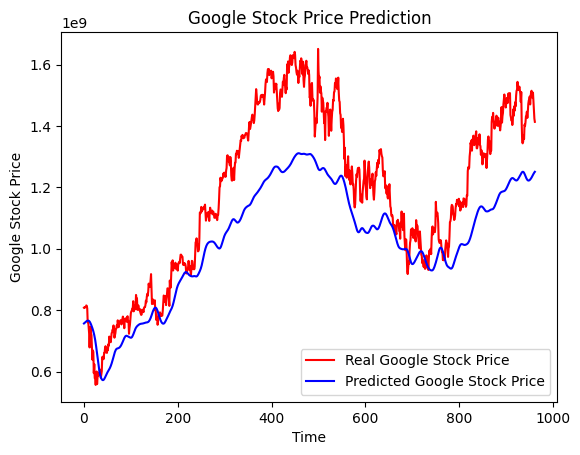

In [14]:

# transform test target variable to original form
y_test = sc.inverse_transform(y_test.reshape(-1, 1))

# visualising the results
plt.plot(y_test, color = "red", label = "Real Google Stock Price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()